# Cost Functions
You need an IBM account to run this notebook
During this lesson, we'll learn how to evaluate a *cost function*:

- First, we'll learn about [Qiskit Runtime primitives](https://docs.quantum.ibm.com/guides/primitives).
- Define a cost function $C(\vec{\theta})$. This is a problem-specific function that defines the problem’s goal for the optimizer to minimize (or maximize).
- Defining a measurement strategy with the Qiskit Runtime primitives to [optimize speed vs accuracy](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/).


![alt text](../../../img/cost_function_workflow.svg)

## Table of Contents

1. [Primitives](#primitives)  
   - [The Sampler Primitive](#the-sampler-primitive)  
   - [The Estimator Primitive](#the-estimator-primitive)  
   - [Guided Example to Calculate Expectation Values](#guided-example-to-calculate-expectation-values)  
   - [Mathematical Rigor (Optional)](#mathematical-rigor-optional)  
2. [Cost Functions](#cost-functions)  
3. [Example Mapping to Non-physical Systems](#example-mapping-to-non-physical-systems)  
4. [Measurement Strategy: Speed versus Accuracy](#measurement-strategy-speed-versus-accuracy)  
5. [Error Suppression](#error-suppression)  
6. [Error Mitigation](#error-mitigation)  
   - [Twirled Readout Error Extinction (T-REx)](#twirled-readout-error-extinction-t-rex)  
   - [Zero Noise Extrapolation](#zero-noise-extrapolation)  
   - [Using Qiskit Runtime's Mitigation and Suppression Options](#using-qiskit-runtimes-mitigation-and-suppression-options)  
7. [Summary](#summary)

## Primitives

All physical systems, whether classical or quantum, can exist in different states. For example, a car on a road can have a certain mass, position, speed, or acceleration that characterize its state. Similarly, quantum systems can also have different configurations or states, but they differ from classical systems in how we deal with measurements and state evolution. This leads to unique properties such as *superposition* and *entanglement* that are exclusive to quantum mechanics. Just like we can describe a car's state using physical properties like speed or acceleration, we can also describe the state of a quantum system using *observables*, which are mathematical objects.

In quantum mechanics, states are represented by normalized complex column vectors, or *kets* ($|\psi\rangle$), and observables are hermitian linear operators ($\hat{H} = \hat{H}^\dagger$) that act on the kets. An eigenvector ($|\lambda\rangle$) of an observable is known as an *eigenstate*. Measuring an observable for one of its eigenstates ($|\lambda\rangle$) will give us the corresponding eigenvalue ($\lambda$) as readout.

If you're wondering how to measure a quantum system and what you can measure, Qiskit offers two primitives that can help:

- `Sampler`: Given a quantum state $|\psi\rangle$, this primitive obtains the probability of each possible computational basis state.
- `Estimator`: Given a quantum observable $\hat{H}$ and a state $|\psi\rangle$, this primitive computes the expected value of $\hat{H}$.



### The Sampler Primitive

The `Sampler` primitive calculates the probability of obtaining each possible state $|k\rangle$ from the computational basis, given a quantum circuit that prepares the state $|\psi\rangle$. It calculates

$$
p_k = |\langle k | \psi \rangle|^2 \quad \forall k \in \mathbb{Z}_2^n \equiv \{0, 1, \cdots, 2^n - 1\},
$$

where $n$ is the number of qubits, and $k$ the integer representation of any possible output binary string $\{0,1\}^n$ (i.e. integers base 2).

Qiskit Runtime's `Sampler` runs the circuit multiple times on a quantum device, performing measurements on each run, and reconstructing the probability distribution from the recovered bit strings. The more runs (or *shots*) it performs, the more accurate the results will be, but this requires more time and quantum resources.

However, since the number of possible outputs grows exponentially with the number of qubits $n$ (i.e. $2^n$), the number of shots will need to grow exponentially as well in order to capture a *dense* probability distribution. Therefore, `Sampler` is only efficient for *sparse* probability distributions; where the target state $|\psi\rangle$ must be expressible as a linear combination of the computational basis states, with the number of terms growing at most polynomially with the number of qubits:

$$
|\psi\rangle = \sum_k^{\text{Poly}(n)} w_k |k\rangle.
$$

The `Sampler` can also be configured to retrieve probabilities from a subsection of the circuit, representing a subset of the total possible states.

### The Estimator Primitive


The `Estimator` primitive calculates the expectation value of an observable $\hat{H}$ for a quantum state $|\psi\rangle$; where the observable probabilities can be expressed as $p_\lambda = |\langle \lambda | \psi \rangle|^2$, being $\{|\lambda\rangle\}$ the eigenstates of the observable $\hat{H}$. The expectation value is then defined as the average of all possible outcomes $\lambda$ (i.e. the eigenvalues of the observable) of a measurement of the state $|\psi\rangle$, weighted by the corresponding probabilities:

$$
\langle \hat{H} \rangle_\psi := \sum_\lambda p_\lambda \lambda = \langle \psi | \hat{H} | \psi \rangle.
$$


However, calculating the expectation value of an observable is not always possible, as we often don't know its eigenbasis.  
[Qiskit Runtime's `Estimator`](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/) uses a complex algebraic process to estimate the expectation value on a real quantum device by breaking down the observable into a combination of other observables whose eigenbasis we do know.

In simpler terms, `Estimator` breaks down any observable that it doesn’t know how to measure into simpler, measurable observables called *Pauli operators*.

Any operator can be expressed as a combination of $4^n$ Pauli operators:

$$
\hat{P}_k := \sigma_{k_{n-1}} \otimes \cdots \otimes \sigma_{k_0} \quad \forall k \in \mathbb{Z}_4^n \equiv \{0, 1, \cdots, 4^n - 1\},
$$

such that

$$
\hat{H} = \sum_{k=0}^{4^n - 1} w_k \hat{P}_k,
$$

where $n$ is the number of qubits, $k = k_{n-1} \cdots k_0$ for $k_i \in \mathbb{Z}_4 \equiv \{0, 1, 2, 3\}$ (i.e. integers base 4), and $(\sigma_0, \sigma_1, \sigma_2, \sigma_3) := (I, X, Y, Z)$.

After performing this decomposition, `Estimator` derives a new circuit $V_k |\psi\rangle$ for each observable $\hat{P}_k$ (i.e. from the original circuit), to effectively *diagonalize* the Pauli observable in the computational basis and measure it. We can easily measure Pauli observables because we know $V_k$ ahead of time, which is not the case generally for other observables.

For each $\hat{P}_k$, the `Estimator` runs the corresponding circuit on a quantum device multiple times, measures the output state in the computational basis, and calculates the probability $p_{kj}$ of obtaining each possible output $j$. It then looks for the eigenvalue $\lambda_{kj}$ of $P_k$ corresponding to each output $j$, multiplies by $w_k$, and adds all the results together to obtain the expected value of the observable $\hat{H}$ for the given state $|\psi\rangle$:

$$
\langle \hat{H} \rangle_\psi = \sum_{k=0}^{4^n - 1} w_k \sum_{j=0}^{2^n - 1} p_{kj} \lambda_{kj}.
$$

Since calculating the expectation value of $4^n$ Paulis is impractical (i.e. exponentially growing), `Estimator` can only be efficient when a large amount of $w_k$ are zero (i.e. *sparse* Pauli decomposition instead of *dense*). Formally we say that, for this computation to be *efficiently solvable*, the number of non-zero terms has to grow at most polynomially with the number of qubits $n$:  
$\hat{H} = \sum_k^{\text{Poly}(n)} w_k \hat{P}_k$.

The reader may notice the implicit assumption that probability *sampling* also needs to be efficient as explained for `Sampler`, which means

$$
\langle \hat{H} \rangle_\psi = \sum_k^{\text{Poly}(n)} w_k \sum_j^{\text{Poly}(n)} p_{kj} \lambda_{kj}.
$$



### Guided Example to Calculate Expectation Values

Let's assume the single-qubit state $|+\rangle := H |0\rangle = \frac{1}{\sqrt{2}} (|0\rangle + |1\rangle)$, and observable

$$
\hat{H} = \begin{pmatrix} -1 & 2 \\ 2 & 1 \end{pmatrix} = 2X - Z.
$$

With the following theoretical expectation value $\langle \hat{H} \rangle_+ = \langle + | \hat{H} | + \rangle = 2$.

Since we do not know how to measure this observable, we cannot compute its expectation value directly, and we need to re-express it as  
$\langle \hat{H} \rangle_+ = 2 \langle X \rangle_+ - \langle Z \rangle_+$.  
Which can be shown to evaluate to the same result by virtue of noting that $\langle + | X | + \rangle = 1$, and $\langle + | Z | + \rangle = 0$.

Let’s see how to compute $\langle X \rangle_+$ and $\langle Z \rangle_+$ directly. Since $X$ and $Z$ do not commute (i.e. don’t share the same eigenbasis), they cannot be measured simultaneously, therefore we need the auxiliary circuits:


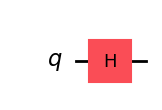

In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp

# The following code will work for any other initial single-qubit state and observable
original_circuit = QuantumCircuit(1)
original_circuit.h(0)

H = SparsePauliOp(["X", "Z"], [2, -1])

aux_circuits = []
for pauli in H.paulis:
    aux_circ = original_circuit.copy()
    aux_circ.barrier()
    if str(pauli) == "X":
        aux_circ.h(0)
    elif str(pauli) == "Y":
        aux_circ.sdg(0)
        aux_circ.h(0)
    else:
        aux_circ.id(0)
    aux_circ.measure_all()
    aux_circuits.append(aux_circ)

original_circuit.draw("mpl")

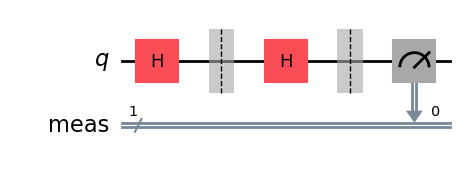

In [2]:
# Auxiliary circuit for X
aux_circuits[0].draw('mpl')

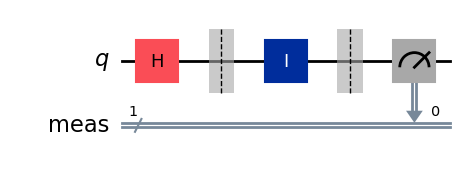

In [3]:
# Auxiliary circuit for Z
aux_circuits[1].draw('mpl')

In [4]:
# We can now carry out the computation manually using Sampler and check the results on Estimator :
from qiskit.primitives import StatevectorSampler, StatevectorEstimator
from qiskit.result import QuasiDistribution
from qiskit.circuit.library import IGate, ZGate, XGate, YGate
import numpy as np


## SAMPLER
shots = 10000
sampler = StatevectorSampler()
job = sampler.run(aux_circuits, shots = shots)
data_pub = job.result()[1].data
bitstrings = data_pub.meas.get_bitstrings()
counts = data_pub.meas.get_counts()
quasi_dist = QuasiDistribution({outcome: freq / shots for outcome, freq in counts.items()})

expvals = []
for pauli in H.paulis:
    val = 0
    
    if str(pauli) == "I":
        Lambda = IGate().to_matrix().real
    
    if str(pauli) == "X":
        Lambda = XGate().to_matrix().real
        val += Lambda[0][1] * quasi_dist.get(1)
        val += Lambda[1][0] * quasi_dist.get(0)
    
    if str(pauli) == "Y":
        Lambda = XGate().to_matrix().real
        val += Lambda[0][1] * 1.j * quasi_dist.get(1)
        val += Lambda[1][0] * -1.j * quasi_dist.get(0)

    if str(pauli) == "Z":
        Lambda = ZGate().to_matrix().real
        val += Lambda[0][0] * quasi_dist.get(0)
        val += Lambda[1][1] * quasi_dist.get(1)
    
    expvals.append(val)

print("Sampler results:")
for (pauli, expval) in zip(H.paulis, expvals):
    print(f"  >> Expected value of {str(pauli)}: {expval:.5f}")

total_expval = np.sum(H.coeffs * expvals).real
print(f"  >> Total expected value: {total_expval:.5f}")

## ESTIMATOR
observables = [
    *H.paulis,H
]  # Note: run for individual Paulis as well as full observable H

estimator = StatevectorEstimator()
job = estimator.run([(original_circuit, observables)])
estimator_expvals = job.result()[0].data.evs

print("Estimator results:")
for (obs, expval) in zip(observables, estimator_expvals):
    if obs is not H:
        print(f"  >> Expected value of {str(obs)}: {expval:.5f}")
    else:
        print(f"  >> Total expected value: {expval:.5f}")

Sampler results:
  >> Expected value of X: 1.00000
  >> Expected value of Z: -0.00420
  >> Total expected value: 2.00420
Estimator results:
  >> Expected value of X: 1.00000
  >> Expected value of Z: 0.00000
  >> Total expected value: 2.00000


### Mathematical Rigor (Optional)

Expressing $|\psi\rangle$ with respect to the basis of eigenstates of $\hat{H}$, $|\psi\rangle = \sum_\lambda a_\lambda |\lambda\rangle$, it follows:

$$
\begin{aligned}
\langle \psi | \hat{H} | \psi \rangle 
&= \left( \sum_{\lambda'} a_{\lambda'}^* \langle \lambda' | \right) \hat{H} \left( \sum_\lambda a_\lambda |\lambda\rangle \right) \\
&= \sum_{\lambda'} \sum_\lambda a_{\lambda'}^* a_\lambda \langle \lambda' | \hat{H} | \lambda \rangle \\
&= \sum_{\lambda'} \sum_\lambda a_{\lambda'}^* a_\lambda \lambda \langle \lambda' | \lambda \rangle \\
&= \sum_{\lambda'} \sum_\lambda a_{\lambda'}^* a_\lambda \lambda \cdot \delta_{\lambda, \lambda'} \\
&= \sum_\lambda |a_\lambda|^2 \lambda \\
&= \sum_\lambda p_\lambda \lambda
\end{aligned}
$$

Since we do not know the eigenvalues or eigenstates of the target observable $\hat{H}$, first we need to consider its diagonalization.  
Given that $\hat{H}$ is hermitian, there exists a unitary transformation $V$ such that $\hat{H} = V^\dagger \Lambda V$, where $\Lambda$ is the diagonal eigenvalue matrix, so $\langle j | \Lambda | k \rangle = 0$ if $j \ne k$, and $\langle j | \Lambda | j \rangle = \lambda_j$.

This implies that the expected value can be rewritten as:

$$
\begin{aligned}
\langle \psi | \hat{H} | \psi \rangle &= \langle \psi | V^\dagger \Lambda V | \psi \rangle \\
&= \langle \psi | V^\dagger \left( \sum_{j=0}^{2^n - 1} |j\rangle \langle j| \right) \Lambda \left( \sum_{k=0}^{2^n - 1} |k\rangle \langle k| \right) V | \psi \rangle \\
&= \sum_{j=0}^{2^n - 1} \sum_{k=0}^{2^n - 1} \langle \psi | V^\dagger | j \rangle \langle j | \Lambda | k \rangle \langle k | V | \psi \rangle \\
&= \sum_{j=0}^{2^n - 1} \langle \psi | V^\dagger | j \rangle \langle j | \Lambda | j \rangle \langle j | V | \psi \rangle \\
&= \sum_{j=0}^{2^n - 1} |\langle j | V | \psi \rangle|^2 \lambda_j
\end{aligned}
$$

Given that if a system is in the state $|\phi\rangle = V |\psi\rangle$ the probability of measuring $|j\rangle$ is $p_j = |\langle j | \phi \rangle|^2$, the above expected value can be expressed as:

$$
\langle \psi | \hat{H} | \psi \rangle = \sum_{j=0}^{2^n - 1} p_j \lambda_j.
$$

It is very important to note that the probabilities are taken from the state $V |\psi\rangle$ instead of $|\psi\rangle$. This is why the matrix $V$ is absolutely necessary.

You might be wondering how to obtain the matrix $V$ and the eigenvalues $\Lambda$. If you already had the eigenvalues, then there would be no need to use a quantum computer since the goal of variational algorithms is to find these eigenvalues of $\hat{H}$.

Fortunately, there is a way around that: any $2^n \times 2^n$ matrix can be written as a linear combination of $4^n$ tensor products of $n$ Pauli matrices and identities, all of which are both hermitian and unitary with known $V$ and $\Lambda$. This is what Runtime’s `Estimator` does internally by decomposing any `Operator` object into a `SparsePauliOp`.

Here are the Operators that can be used:

| **Operator** | $\sigma$                              | $V$                                                                                  | $\Lambda$                                                   |
|--------------|----------------------------------------|--------------------------------------------------------------------------------------|--------------------------------------------------------------|
| $I$          | $\sigma_0 = \begin{pmatrix}1 & 0 \\ 0 & 1\end{pmatrix}$ | $V_0 = I$                                                                       | $\Lambda_0 = I = \begin{pmatrix}1 & 0 \\ 0 & 1\end{pmatrix}$ |
| $X$          | $\sigma_1 = \begin{pmatrix}0 & 1 \\ 1 & 0\end{pmatrix}$ | $V_1 = H = \frac{1}{\sqrt{2}} \begin{pmatrix}1 & 1 \\ 1 & -1\end{pmatrix}$     | $\Lambda_1 = \sigma_3 = \begin{pmatrix}1 & 0 \\ 0 & -1\end{pmatrix}$ |
| $Y$          | $\sigma_2 = \begin{pmatrix}0 & -i \\ i & 0\end{pmatrix}$ | $V_2 = HS^\dagger = \frac{1}{\sqrt{2}} \begin{pmatrix}1 & 1 \\ 1 & -1\end{pmatrix} \begin{pmatrix}1 & 0 \\ 0 & -i\end{pmatrix} = \frac{1}{\sqrt{2}} \begin{pmatrix}1 & -i \\ 1 & i\end{pmatrix}$ | $\Lambda_2 = \sigma_3 = \begin{pmatrix}1 & 0 \\ 0 & -1\end{pmatrix}$ |
| $Z$          | $\sigma_3 = \begin{pmatrix}1 & 0 \\ 0 & -1\end{pmatrix}$ | $V_3 = I$                                                                       | $\Lambda_3 = \sigma_3 = \begin{pmatrix}1 & 0 \\ 0 & -1\end{pmatrix}$ |

---

So let’s rewrite $\hat{H}$ with respect to the Paulis and identities:

$$
\hat{H} = \sum_{k_{n-1} = 0}^3 \cdots \sum_{k_0 = 0}^3 w_{k_{n-1}, \ldots, k_0} \sigma_{k_{n-1}} \otimes \cdots \otimes \sigma_{k_0} = \sum_{k=0}^{4^n - 1} w_k \hat{P}_k,
$$

where $k = \sum_{i=0}^{n-1} 4^i k_i \equiv k_{n-1} \cdots k_0$ for $k_i \in \{0, 1, 2, 3\}$ (i.e. base 4), and $\hat{P}_k := \sigma_{k_{n-1}} \otimes \cdots \otimes \sigma_{k_0}$.

$$
\langle \psi | \hat{H} | \psi \rangle = \sum_{k=0}^{4^n - 1} w_k \sum_{j=0}^{2^n - 1} |\langle j | V_k | \psi \rangle|^2 \langle j | \Lambda_k | j \rangle = \sum_{k=0}^{4^n - 1} w_k \sum_{j=0}^{2^n - 1} p_{kj} \lambda_{kj},
$$

where $V_k := V_{k_{n-1}} \otimes \cdots \otimes V_{k_0}$ and $\Lambda_k := \Lambda_{k_{n-1}} \otimes \cdots \otimes \Lambda_{k_0}$ such that:  
$\hat{P}_k = V_k^\dagger \Lambda_k V_k$.



## Cost Functions

In general, cost functions are used to describe the goal of a problem and how well a trial state is performing with respect to that goal. This definition can be applied to various examples in chemistry, machine learning, finance, optimization, and so on.

Let’s consider a simple example of finding the ground state of a system. Our objective is to minimize the expectation value of the observable representing energy (Hamiltonian $\hat{H}$):

$$
\min_{\vec{\theta}} \langle \psi(\vec{\theta}) | \hat{H} | \psi(\vec{\theta}) \rangle
$$

We can use the `Estimator` to evaluate the expectation value and pass this value to an optimizer to minimize. If the optimization is successful, it will return a set of optimal parameter values $\vec{\theta}^*$, from which we will be able to construct the proposed solution state $|\psi(\vec{\theta}^*)\rangle$ and compute the observed expectation value as $C(\vec{\theta}^*)$.

Notice how we will only be able to minimize the cost function for the limited set of states that we are considering. This leads us to two separate possibilities:

- **Our ansatz does not define the solution state across the search space**: If this is the case, our optimizer will never find the solution, and we need to experiment with other ansatzes that might be able to represent our search space more accurately.
- **Our optimizer is unable to find this valid solution**: Optimization can be globally defined and locally derailed. We’ll explore what this means in the later section.

All in all, we will be performing a classical optimization loop but relying on the evaluation of the cost function to a quantum computer. From this perspective, one could think of the optimization as a purely classical endeavor where we call some black-box quantum oracle each time the optimizer needs to evaluate the cost function.

In [5]:
def cost_func_vqe(params, circuit, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (circuit, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs
    return cost

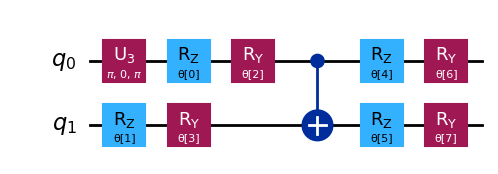

In [6]:
from qiskit.circuit.library import TwoLocal

observable = SparsePauliOp.from_list([("XX", 1), ("YY", -3)])

reference_circuit = QuantumCircuit(2)
reference_circuit.x(0)

variational_form = TwoLocal(
    2,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
)
ansatz = reference_circuit.compose(variational_form)

theta_list = (2 * np.pi * np.random.rand(1, 8)).tolist()
ansatz.decompose().draw('mpl')

We will first carry this out using a simulator: the StatevectorEstimator. This is usually advisable for debugging, but we will immediately follow the debugging run with a calculation on real quantum hardware. Increasingly, problems of interest are no longer classically simulable without state-of-the-art supercomputing facilities.

In [7]:
estimator = StatevectorEstimator()
cost = cost_func_vqe(theta_list, ansatz, observable, estimator)
print(cost)

[-0.01271685]


We will now proceed with running on a real quantum computer. Note the syntax changes. The steps involving the pass_manager will be discussed further in the next example. One step of particular importance in variational algorithms is the use of a Qiskit Runtime session. Starting a session allows you to run multiple iterations of a variational algorithm without waiting in a new queue each time parameters are updated. This is important if queue times are long and/or many iterations are needed. Only partners in the IBM Quantum Network can use Runtime sessions. If you do not have access to sessions, you can reduce the number of iterations you submit at a given time, and save the most recent parameters for use in future runs. If you submit too many iterations or encounter queue times that are too long, you may encounter error code 1217, which refers to long delays between job submissions.

In [8]:
#Estimated usage: < 1 min. Benchmarked at 7 seconds on ibm_osaka, 5-23-24
#Load necessary packages:

from qiskit_ibm_runtime import QiskitRuntimeService, Session, EstimatorOptions, EstimatorV2 as Estimator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

#Select the least busy backend:

service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(
    operational=True, min_num_qubits=ansatz.num_qubits, simulator=False
)
#Or get a specific backend:
#backend = service.backend("ibm_cusco")

#Use a pass manager to transpile the circuit and observable for the specific backend being used:

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_ansatz = pm.run(ansatz)
isa_observable = observable.apply_layout(layout = isa_ansatz.layout)


# Set estimator options
estimator_options = EstimatorOptions(
    resilience_level=1,
    default_shots = 10_000
)

# Open a Runtime session:

with Session(backend=backend) as session:
    estimator = Estimator(mode=session, options = estimator_options)
    cost = cost_func_vqe(theta_list, isa_ansatz, isa_observable, estimator)

session.close()
print(cost)

AccountNotFoundError: 'Unable to find account.'

Note that the values obtained from the two calculations above are very similar. Techniques for improving results will be discussed further below.

## Example Mapping to Non-physical Systems

The maximum cut (Max-Cut) problem is a combinatorial optimization problem that involves dividing the vertices of a graph into two disjoint sets such that the number of edges between the two sets is maximized. More formally, given an undirected graph $G=(V,E)$, where $V$ is the set of vertices and $E$ is the set of edges, the Max-Cut problem asks to partition the vertices into two disjoint subsets, $S$ and $T$, such that the number of edges with one endpoint in $S$ and the other in $T$ is maximized.

We can apply Max-Cut to solve a various problems including: clustering, network design, phase transitions, etc. We'll start by creating a problem graph:

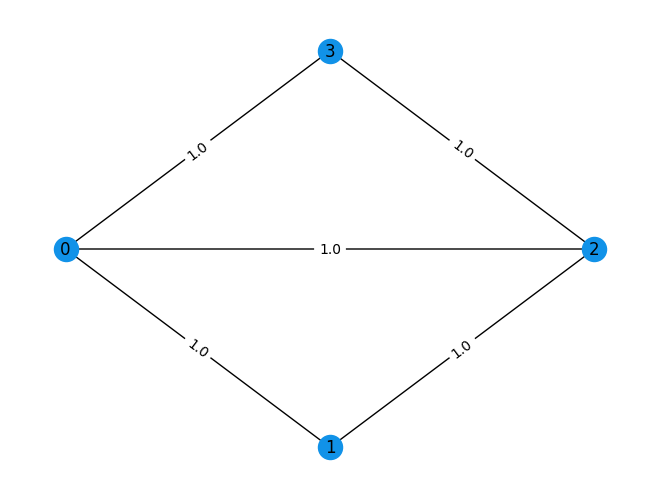

In [9]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw

n = 4
G = rx.PyGraph()
G.add_nodes_from(range(n))
# The edge syntax is (start, end, weight)
edges = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0)]
G.add_edges_from(edges)

mpl_draw(G, pos=rx.shell_layout(G), with_labels=True, edge_labels=str, node_color="#1192E8")

This problem can be expressed as a binary optimization problem. For each node $0 \leq i < n$, where $n$ is the number of nodes of the graph (in this case $n = 4$), we will consider the binary variable $x_i$. This variable will have the value 1 if node $i$ is one of the groups that we'll label 1 and 0 if it's in the other group, that we'll label as 0. We will also denote as $w_{ij}$ (element $(i, j)$ of the adjacency matrix $w$) the weight of the edge that goes from node $i$ to node $j$. Because the graph is undirected, $w_{ij} = w_{ji}$. Then we can formulate our problem as maximizing the following cost function:

$$
\begin{aligned}
C(\vec{x}) &= \sum_{i,j=0}^{n} w_{ij} x_i (1 - x_j) \\
&= \sum_{i,j=0}^{n} w_{ij} x_i - \sum_{i,j=0}^{n} w_{ij} x_i x_j \\
&= \sum_{i,j=0}^{n} w_{ij} x_i - \sum_{i=0}^{n} \sum_{j=0}^{i} 2 w_{ij} x_i x_j
\end{aligned}
$$

To solve this problem with a quantum computer, we are going to express the cost function as the expected value of an observable. However, the observables that Qiskit admits natively consist of Pauli operators, that have eigenvalues 1 and $-1$ instead of 0 and 1. That’s why we are going to make the following change of variable:

Where $\vec{x} = (x_0, x_1, \cdots, x_{n-1})$. We can use the adjacency matrix $w$ to comfortably access the weights of all the edges. This will be used to obtain our cost function:

$$
z_i = 1 - 2x_i \rightarrow x_i = \frac{1 - z_i}{2}
$$

This implies that:

$$
\begin{aligned}
x_i = 0 &\rightarrow z_i = 1 \\
x_i = 1 &\rightarrow z_i = -1
\end{aligned}
$$

So the new cost function we want to maximize is:

$$
\begin{aligned}
C(\vec{z}) &= \sum_{i,j=0}^{n} w_{ij} \left( \frac{1 - z_i}{2} \right) \left( \frac{1 - z_j}{2} \right) \\
&= \sum_{i,j=0}^{n} \frac{w_{ij}}{4} - \sum_{i,j=0}^{n} \frac{w_{ij}}{4} z_i z_j \\
&= \sum_{i=0}^{n} \sum_{j=0}^{i} \frac{w_{ij}}{2} - \sum_{i=0}^{n} \sum_{j=0}^{i} \frac{w_{ij}}{2} z_i z_j
\end{aligned}
$$

Moreover, the natural tendency of a quantum computer is to find minima (usually the lowest energy) instead of maxima so instead of maximizing $C(\vec{z})$ we are going to minimize:

$$
-C(\vec{z}) = \sum_{i=0}^{n} \sum_{j=0}^{i} \frac{w_{ij}}{2} z_i z_j - \sum_{i=0}^{n} \sum_{j=0}^{i} \frac{w_{ij}}{2}
$$

Now that we have a cost function to minimize whose variables can have the values $-1$ and $1$, we can make the following analogy with the Pauli $Z$:

$$
z_i = Z_i = \underbrace{I \otimes \cdots \otimes}_{n-1} \underbrace{Z}_{i^{\text{th}}} \underbrace{\otimes \cdots \otimes I}_{0^{\text{th}}}
$$

In other words, the variable $z_i$ will be equivalent to a $Z$ gate acting on qubit $i$. Moreover:

$$
Z_i |x_{n-1} \cdots x_0\rangle = z_i |x_{n-1} \cdots x_0\rangle \rightarrow \langle x_{n-1} \cdots x_0 | Z_i | x_{n-1} \cdots x_0 \rangle = z_i
$$

Then the observable we are going to consider is:

$$
\hat{H} = \sum_{i=0}^{n} \sum_{j=0}^{i} \frac{w_{ij}}{2} Z_i Z_j
$$

to which we will have to add the independent term afterwards:

$$
\text{offset} = -\sum_{i=0}^{n} \sum_{j=0}^{i} \frac{w_{ij}}{2}
$$

The operator is a linear combination of terms with $Z$ operators on nodes connected by an edge (recall that the 0th qubit is farthest right):  
$IIZZ + IZIZ + IZZI + ZIIZ + ZZII$.  
Once the operator is constructed, the ansatz for the QAOA algorithm can easily be built by using the `QAOAAnsatz` circuit from the Qiskit circuit library.



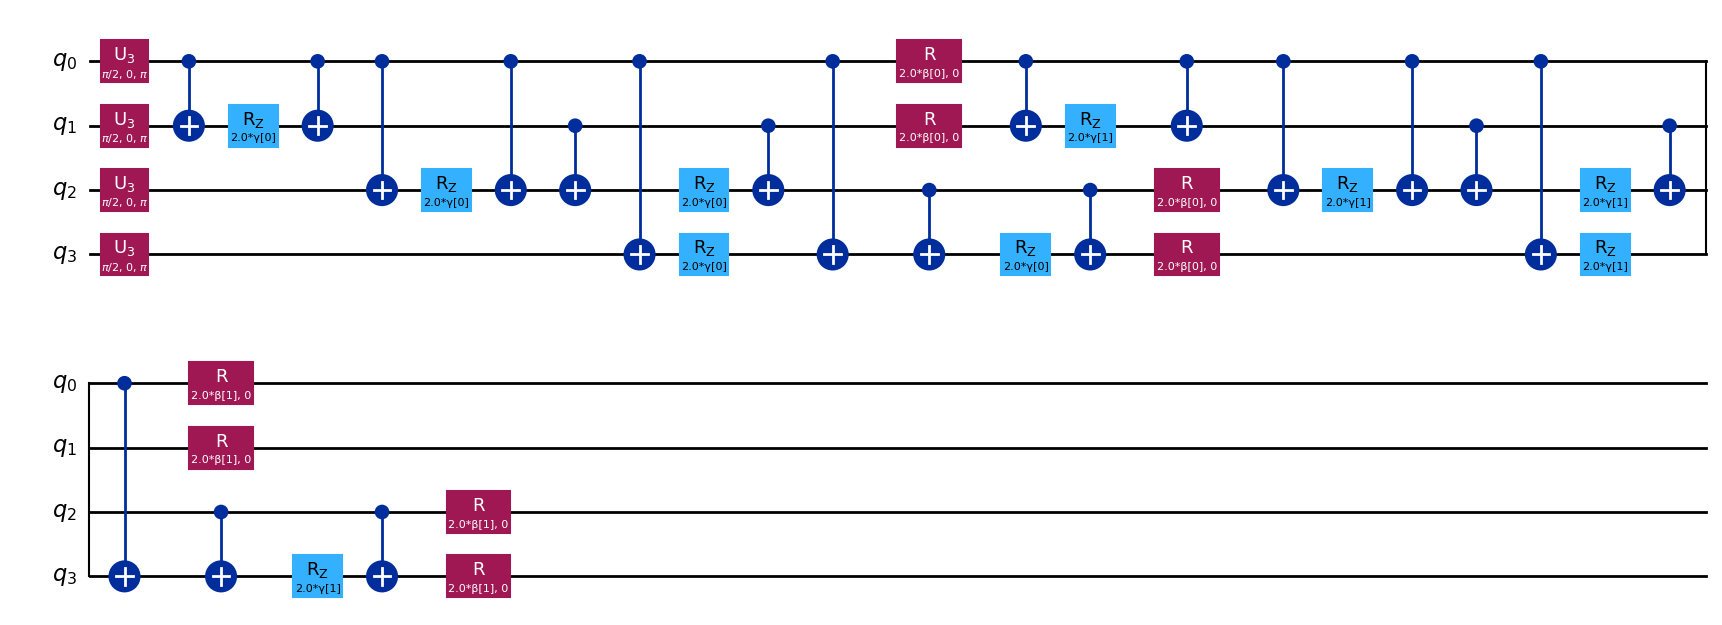

In [10]:
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp

hamiltonian = SparsePauliOp.from_list([
    ("IIZZ", 1), ("IZIZ", 1), ("IZZI", 1), ("ZIIZ", 1), ("ZZII", 1)
])


ansatz = QAOAAnsatz(hamiltonian, reps=2)
# Draw
ansatz.decompose(reps=3).draw("mpl")

In [11]:
# Sum the weights, and divide by 2

offset = - sum(edge[2] for edge in edges) / 2
print(f"""Offset: {offset}""")

Offset: -2.5


With the Runtime Estimator directly taking a Hamiltonian and parameterized ansatz, and returning the necessary energy, The cost function for a QAOA instance is quite simple:

In [12]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs
#    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

In [13]:
import numpy as np

x0 = 2 * np.pi * np.random.rand(ansatz.num_parameters)

estimator = StatevectorEstimator()
cost = cost_func_vqe(x0, ansatz, hamiltonian, estimator)
print(cost)

0.9193949539399506


In [14]:
#Estimated usage: < 1 min, benchmarked at 6 seconds on ibm_osaka, 5-23-24
#Load some necessary packages:

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator

#Select the least busy backend:

backend = service.least_busy(
    operational=True, min_num_qubits=ansatz.num_qubits, simulator=False
)

#Or get a specific backend:
#backend = service.backend("ibm_cusco")

#Use a pass manager to transpile the circuit and observable for the specific backend being used:

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_ansatz = pm.run(ansatz)
isa_hamiltonian = hamiltonian.apply_layout(layout = isa_ansatz.layout)

# Set estimator options
estimator_options = EstimatorOptions(
    resilience_level=1,
    default_shots = 10_000
)

# Open a Runtime session:

with Session(backend=backend) as session:
    estimator = Estimator(mode=session, options = estimator_options)
    cost = cost_func_vqe(x0, isa_ansatz, isa_hamiltonian, estimator)

# Close session after done
session.close()
print(cost)

NameError: name 'service' is not defined

We will revisit this example in Applications to explore how to leverage an optimizer to iterate through the search space. Generally speaking, this includes:

- Leveraging an optimizer to find optimal parameters
- Binding optimal parameters to the ansatz to find the eigenvalues
- Translating the eigenvalues to our problem definition

## Measurement Strategy: Speed versus Accuracy

As mentioned, we are using a noisy quantum computer as a black-box oracle, where noise can make the retrieved values non-deterministic, leading to random fluctuations which, in turn, will harm — or even completely prevent — convergence of certain optimizers to a proposed solution. This is a general problem that we must address as we incrementally explore quantum utility and progress towards quantum advantage:

![alt text](../../../img/cost_function_path_to_quantum_advantage.svg)

We can use Qiskit Runtime Primitive's error suppression and error mitigation options to address noise and maximize the utility of today's quantum computers.

## Error Suppression

Error suppression refers to techniques used to optimize and transform a circuit during compilation in order to minimize errors. This is a basic error handling technique that usually results in some classical pre-processing overhead to the overall runtime. The overhead includes transpiling circuits to run on quantum hardware by:

- Expressing the circuit using the native gates available on a quantum system
- Mapping the virtual qubits to physical qubits
- Adding SWAPs based on connectivity requirements
- Optimizing 1Q and 2Q gates
- Adding dynamical decoupling to idle qubits to prevent the effects of decoherence.

Primitives allow for the use of error suppression techniques by setting the optimization_level option and selecting advanced transpilation options. In a later course, we will delve into different circuit construction methods to improve results, but for most cases, we recommend setting optimization_level=3 .

We will visualize the value of increasing optimization in the transpilation process by looking at an example circuit with a simple ideal behavior.


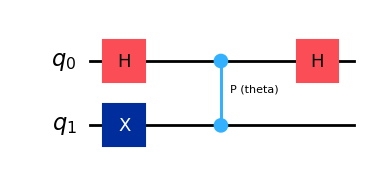

In [15]:
from qiskit.circuit import Parameter, QuantumCircuit
from qiskit.quantum_info import SparsePauliOp

theta = Parameter("theta")

qc = QuantumCircuit(2)
qc.x(1)
qc.h(0)
qc.cp(theta, 0, 1)
qc.h(0)
observables = SparsePauliOp.from_list([("ZZ", 1)])

qc.draw("mpl")

The circuit above can yield sinusoidal expectation values of the observable given, provided we insert phases spanning an appropriate interval, such as $[0,2\pi]$

In [16]:
## Setup phases
import numpy as np

phases = np.linspace(0, 2*np.pi, 50)

# phases need to be expressed as a list of lists in order to work
individual_phases = [[phase] for phase in phases]

We can now use a pass manager to transpile the circuit into the "instruction set architecture" or ISA of the backend. This is a new requirement in Qiskit Runtime: all circuits submitted to a backend must conform to the constraints of the backend’s target, meaning they must be written in terms of the backend's ISA — i.e., the set of instructions the device can understand and execute. These target constraints are defined by factors like the device’s native basis gates, its qubit connectivity, and - when relevant - its pulse and other instruction timing specifications.

Note that in the present case, we will do this twice: once with optimization_level = 0, and once with it set to 3. Each time we will use the Estimator primitive to estimate the expectation values of the observable at different values of phase.

In [17]:
#Import estimator and specify that we are using the simulated backend:

from qiskit_ibm_runtime import EstimatorV2 as Estimator
estimator = Estimator(mode = backend_sim)

circuit = qc

#Use a pass manager to transpile the circuit and observable for the backend being simulated.
#Start with no optimization:

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend_sim, optimization_level=0)
isa_circuit = pm.run(circuit)
isa_observables = observables.apply_layout(layout = isa_circuit.layout)

noisy_exp_values = []
pub = (isa_circuit, isa_observables, [individual_phases])
cost = estimator.run([pub]).result()[0].data.evs
noisy_exp_values = cost[0]

#Repeat above steps, but now with optimization = 3:

exp_values_with_opt_es = []
pm = generate_preset_pass_manager(backend=backend_sim, optimization_level=3)
isa_circuit = pm.run(circuit)
isa_observables = observables.apply_layout(layout = isa_circuit.layout)

pub = (isa_circuit, isa_observables, [individual_phases])
cost = estimator.run([pub]).result()[0].data.evs
exp_values_with_opt_es = cost[0]

NameError: name 'backend_sim' is not defined

Finally, we can plot the results, and we see that the precision of the calculation was fairly good even without optimization, but it definitely improved by increasing optimization to level 3. Note that in deeper, more complicated circuits, the difference between optimization levels of 0 and 3 are likely to be more significant. This is a very simple circuit used as a toy model.

In [18]:
import matplotlib.pyplot as plt

plt.plot(phases, noisy_exp_values, "o", label="opt=0")
plt.plot(phases, exp_values_with_opt_es, "o", label="opt=3")
plt.plot(phases, 2 * np.sin(phases / 2) ** 2 - 1, label="ideal")
plt.ylabel("Expectation")
plt.legend()
plt.show()

NameError: name 'noisy_exp_values' is not defined

## Error Mitigation

Error mitigation refers to techniques that allow users to reduce circuit errors by modeling the device noise at the time of execution. Typically, this results in quantum pre-processing overhead related to model training and classical post-processing overhead to mitigate errors in the raw results by using the generated model.

The Qiskit Runtime primitive's resilience_level option specifies the amount of resilience to build against errors. Higher levels generate more accurate results at the expense of longer processing times due to quantum sampling overhead. Resilience levels can be used to configure the trade-off between cost and accuracy when applying error mitigation to your primitive query.

When implementing any error mitigation technique, we expect the bias in our results to be reduced with respect to the previous, unmitigated bias. In some cases, the bias may even disappear. However, this comes at a cost. As we reduce the bias in our estimated quantities, the statistical variability will increase (that is, variance), which we can account for by further increasing the number of shots per circuit in our sampling process. This will introduce overhead beyond that needed to reduce the bias, so it is not done by default. We can easily opt-in to this behavior by adjusting the number of shots per circuit in options.executions.shots, as shown in the example below.

![alt text](../../../img/cost_function_bias_variance_trade_off.svg)

For this course, we will explore these error mitigation models at a high level to illustrate the error mitigation that Qiskit Runtime primitives can perform without requiring full implementation details.

### Twirled Readout Error Extinction (T-REx)

Twirled readout error extinction (T-REx) uses a technique known as Pauli twirling to reduce the noise introduced during the process of quantum measurement. This technique assumes no specific form of noise, which makes it very general and effective.

Overall workflow:

1. Acquire data for the zero state with randomized bit flips (Pauli X before measurement)
2. Acquire data for the desired (noisy) state with randomized bit flips (Pauli X before measurement)
3. Compute the special function for each data set, and divide.

![alt text](../../../img/cost_function_trex_data_collection.svg)

We can set this with `options.resilience_level = 1` , demonstrated in the example below.


### Zero Noise Extrapolation

Zero noise extrapolation (ZNE) works by first amplifying the noise in the circuit that is preparing the desired quantum state, obtaining measurements for several different levels of noise, and using those measurements to infer the noiseless result.

Overall workflow:

1. Amplify circuit noise for several noise factors
2. Run every noise amplified circuit
3. Extrapolate back to the zero noise limit

![alt text](../../../img/cost_function_zne_stages.svg)

We can set this with `options.resilience_level = 2`. We can optimize this further by exploring a variety of `noise_factors`, `noise_amplifiers`, and `extrapolators`, but this is outside the scope of this course. We encourage you to experiment with these options [as described here](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/how_to/error-mitigation.html).

Each method comes with its own associated overhead: a trade-off between the number of quantum computations needed (time) and the accuracy of our results:

| Methods            | $R = 1$, T-REx       | $R = 2$, ZNE                        |
|--------------------|----------------------|-------------------------------------|
| Assumptions        | None                 | Ability to scale noise              |
| Qubit overhead     | 1                    | 1                                   |
| Sampling overhead  | 2                    | $N_{\text{noise-factors}}$          |
| Bias               | 0                    | $\mathcal{O}(\lambda^{N_{\text{noise-factors}}})$ |



### Using Qiskit Runtime's Mitigation and Suppression Options

Here’s how to calculate an expectation value while using error mitigation and suppression in Qiskit Runtime. We can make use of precisely the same circuit and observable as before, but this time keeping the optimization level fixed at level 2, and now tuning the *resilience* or the error mitigation technique(s) being used. This error mitigation process occurs multiple times throughout an optimization loop.

We perform this part on real hardware, since error mitigation is not available on simulators.



In [19]:
# Estimated usage: 8 minutes, benchmarked on ibm_sherbrooke, 5-23-24

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Options, Session, EstimatorOptions, EstimatorV2 as Estimator

# We select the least busy backend

# Select the least busy backend
#backend = service.least_busy(
#    operational=True, min_num_qubits=ansatz.num_qubits, simulator=False
#)

# Or use a specific backend
backend = service.backend("ibm_cusco")

#Initialize some variables to save the results from different runs:

exp_values_with_em0_es = []
exp_values_with_em1_es = []
exp_values_with_em2_es = []

#Use a pass manager to optimize the circuit and observables for the backend chosen:

pm = generate_preset_pass_manager(backend=backend, optimization_level=2)
isa_circuit = pm.run(circuit)
isa_observables = observables.apply_layout(layout = isa_circuit.layout)

# Open a session and run with no error mitigation:

estimator_options = EstimatorOptions(
    resilience_level=0,
    default_shots = 10_000
)

with Session(backend=backend) as session:


    estimator = Estimator(mode=session, options = estimator_options)
    
    pub = (isa_circuit, isa_observables, [individual_phases])
    cost = estimator.run([pub]).result()[0].data.evs

session.close()

exp_values_with_em0_es = cost[0]

# Open a session and run with resilience = 1:

estimator_options = EstimatorOptions(
    resilience_level=1,
    default_shots = 10_000
)

with Session(backend=backend) as session:

    estimator = Estimator(mode=session, options = estimator_options)
    
    pub = (isa_circuit, isa_observables, [individual_phases])
    cost = estimator.run([pub]).result()[0].data.evs

session.close()

exp_values_with_em1_es = cost[0]

# Open a session and run with resilience = 2:

estimator_options = EstimatorOptions(
    resilience_level=2,
    default_shots = 10_000
)

with Session(backend=backend) as session:

    estimator = Estimator(mode=session, options = estimator_options)

    pub = (isa_circuit, isa_observables, [individual_phases])
    cost = estimator.run([pub]).result()[0].data.evs

session.close()

exp_values_with_em2_es = cost[0]

NameError: name 'service' is not defined

As before, we can plot the resulting expectation values as a function of phase angle for the three levels of error mitigation used. With great difficulty, one can see that error mitigation improves the results slightly. Again, this effect is much more pronounced in deeper, more complicated circuits.


In [20]:
import matplotlib.pyplot as plt

plt.plot(phases, exp_values_with_em0_es, "o", label="unmitigated")
plt.plot(phases, exp_values_with_em1_es, "o", label="resil = 1")
plt.plot(phases, exp_values_with_em2_es, "o", label="resil = 2")
plt.plot(phases, 2 * np.sin(phases / 2) ** 2 - 1, label="ideal")
plt.ylabel("Expectation")
plt.legend()
plt.show()

NameError: name 'exp_values_with_em0_es' is not defined

## Summary

With this lesson, you learned how to create a cost function:

- Create a cost function
- How to leverage Qiskit Runtime primitives to mitigate and suppression noise
- How to define a measurement strategy to optimize speed vs accuracy

Here's our high-level variational workload:

![alt text](../../../img/cost_function_circuit.svg)

In [21]:
import qiskit
import qiskit_ibm_runtime
print(qiskit.version.get_version_info())
print(qiskit_ibm_runtime.version.get_version_info())

2.0.0
0.40.1
